In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

TIME_COLUMN = "Execution time series"
def read_dataset(filename):
    df = pd.read_csv(filename, index_col=0)
    for column in ["Stars", "Size", "Mentionable Users", "Commits"]:
        df[column] = df[column].astype('int')

    df = df.drop_duplicates(subset=['Repository'])
    df = df.query('Commits >= 100 & Language != None')
    # Repos less or equal 1Gb size
    df = df.query('Size <= 1000000')
    df = df[df[TIME_COLUMN] != "0.0"]
    
    df[TIME_COLUMN] = df[TIME_COLUMN].astype('object')
    df["Bus Factor"] = df["Bus Factor"].astype('int')
    return df

df = read_dataset("data/result.csv")
df

,Repository,Clone URL,Stars,Size,Mentionable Users,Commits,Language,Bus Factor,Execution time series
0,public-apis/public-apis,https://github.com/public-apis/public-apis.git,240702,4948,1262,421,Python,1,"[3753, 2048, 1927, 1899, 1906, 1875, 1853, 184..."
1,facebook/react,https://github.com/facebook/react.git,207783,323598,1708,1160,JavaScript,2,"[3400, 2063, 2059, 2026, 2043, 2029, 2024, 201..."
2,trekhleb/javascript-algorithms,https://github.com/trekhleb/javascript-algorit...,170160,13236,198,135,JavaScript,1,"[438, 254, 247, 239, 250, 240, 240, 238, 236, ..."
3,ohmyzsh/ohmyzsh,https://github.com/ohmyzsh/ohmyzsh.git,159076,10221,2183,622,Shell,9,"[1806, 1030, 1026, 1020, 1025, 1011, 1018, 102..."
4,TheAlgorithms/Python,https://github.com/TheAlgorithms/Python.git,158882,13434,1024,428,Python,2,"[1238, 1072, 694, 699, 704, 704, 701, 690, 690..."
...,...,...,...,...,...,...,...,...,...
1656,gopherjs/gopherjs,https://github.com/gopherjs/gopherjs.git,11930,7108,60,197,Go,2,"[708, 544, 358, 364, 385, 381, 406, 381, 379, ..."
1664,Schniz/fnm,https://github.com/Schniz/fnm.git,11876,3879,70,196,Rust,1,"[604, 368, 364, 366, 364, 343, 354, 351, 373, ..."
1668,slackhq/nebula,https://github.com/slackhq/nebula.git,11802,2066,78,107,Go,2,"[314, 197, 196, 201, 186, 202, 188, 203, 208, ..."
1682,aws/aws-cli,https://github.com/aws/aws-cli.git,13777,116267,355,1390,Python,2,"[3000, 1954, 1911, 1983, 1943, 1905, 1936, 194..."


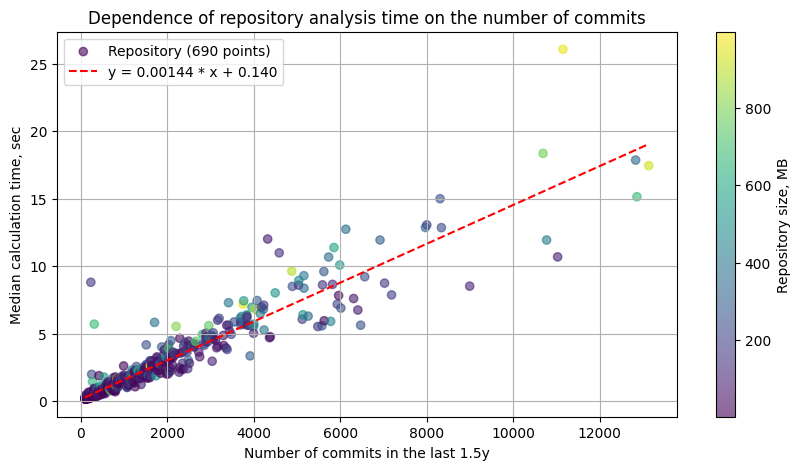

,Stars,Size,Mentionable Users,Commits,Bus Factor,Time_median,Size_in_Mb
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,29949.928986,126874.968116,461.669565,1377.414493,2.242029,2.123690,126.874968
std,25310.096514,182589.329078,764.152411,1862.422464,2.087554,2.836422,182.589329
min,9049.000000,517.000000,1.000000,100.000000,1.000000,0.141000,0.517000
25%,16675.750000,16636.000000,127.250000,263.250000,1.000000,0.431250,16.636000
50%,21644.000000,54873.000000,251.000000,637.000000,2.000000,1.024500,54.873000
75%,33057.000000,149228.250000,496.750000,1650.500000,3.000000,2.489375,149.228250
max,240702.000000,998104.000000,10000.000000,13131.000000,21.000000,26.084000,998.104000


In [2]:
from scipy.optimize import curve_fit
import json
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

test = df
test = test[test.Commits <= 13500]

test['Time_median'] = test[TIME_COLUMN].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
test['Time_median'] = test['Time_median'].apply(lambda x: statistics.median(x) / 1000)

def objective(x, a, b):
     return a * x + b

for category in ['Commits']:
    min_x = test[category].min()
    max_x = test[category].max()
    step_x = int((max_x - min_x) / len(test))
    xticks = [int(min_x + step_x * i) for i in range(len(test))]  

    test.sort_values(by=[category], inplace=True)

    x = test[category].tolist()
    y = test['Time_median'].tolist()
    test['Size_in_Mb'] = test['Size'].apply(lambda x: x * 0.001)
    size = test['Size_in_Mb'].values

    fig, ax = plt.subplots(figsize=(10, 5))
    scatter = ax.scatter(x, y, c=size, label=f'Repository ({len(test)} points)', alpha=0.6)
    #ax = test.plot(x=category, y='Time_median', ylabel="Median calculation time, sec", legend=True, grid=True, figsize=(10,5), kind='scatter')

    # Create a fitting curve
    popt, _ = curve_fit(objective, x, y)
    # summarize the parameter values
    a, b = popt
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 1)
    # calculate the output for the range
    y_line = objective(x_line, a, b)
    # create a line plot for the mapping function
    ax.plot(x_line, y_line, '--', color='red', label = 'y = %.5f * x + %.3f' % (a, b))

    plt.title("Dependence of repository analysis time on the number of commits")
    plt.xlabel("Number of commits in the last 1.5y")
    plt.ylabel("Median calculation time, sec")
    ax.legend()
    ax.grid(True)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Repository size, MB')

    plt.savefig("chart.pdf", format="pdf", bbox_inches="tight")
    plt.show()
        
test.describe()
    